# Wi-Fi Fingerprinting

## Import modules and set up the environment

In [1]:
%matplotlib inline
from IPython.display import display

import getopt                                         # C-style parser for command line options
import os                                             # Miscellaneous operating system interfaces

import sys                                            # System-specific parameters and functions
import math                                           # Mathematical functions
import time                                           # Time access and conversions

import numpy as np                                    # NumPy
import scipy as sp                                    # SciPy
import pandas as pd                                   # Pandas
pd.set_option('display.max_rows', 10000)              # Increase Pandas maximum rows display

import matplotlib.pyplot as plt                       # Matplotlib
import seaborn as sns                                 # Seaborn
sns.despine()                                         # Removing spines

from sklearn import preprocessing                     # scikit-learn preprocessing data
from sklearn.model_selection import GridSearchCV      # scikit-learn model selection GridSearchCV
from sklearn.model_selection import train_test_split  # scikit-learn model selection train_test_split
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import classification_report     # scikit-learn metrics classification_report

import statsmodels.api as sm

c:\developmenttools\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Load the model classes

A class responsible for loading a JSON file (or all the JSON files in a given directory) into a Python dictionary

In [2]:
from yanux.cruncher.model.loader import JsonLoader

A class that takes a set of Python dictionaries containing Wi-Fi logging data loaded from JSON files collected by the YanuX Scavenger Android application

In [3]:
from yanux.cruncher.model.wifi import WifiLogs

Some general helper functions

In [4]:
from yanux.cruncher.ml.experiments import *

## Initialize Input & Output Data Directories and other parameters

In [5]:
input_data_directory = "data"
output_data_directory = "out"

### Create the output directory if it doesn't exist

In [6]:
if not os.path.exists(output_data_directory):
    os.makedirs(output_data_directory)

## Load Data from the Input Data Directory

Load all files from the *data* folder.
The logs currently placed there were collected using the **Yanux Scavenger** Android application on April 28<sup>th</sup>, 2016 using an LG Nexus 5 running Androdid Marshmallow 6.0.1

In [7]:
json_loader = JsonLoader(input_data_directory+"/wifi-fingerprints")
wifi_logs = WifiLogs(json_loader.json_data)

## Wi-Fi Readings

Number of Recorded Samples per Location

In [8]:
num_samples_per_location = int(len(wifi_logs.wifi_samples()) / len(wifi_logs.locations))
num_samples_per_location

40

Store the data into a Pandas Dataframe, in which each Wi-Fi result reading is represented by a single line

In [9]:
wifi_results_columns = ["filename", "place", "floor", "x", "y", "orientation", "sample_id", "mac_address",
                        "timestamp", "signal_strength"]

wifi_results = pd.DataFrame(wifi_logs.wifi_results(), columns=wifi_results_columns)
wifi_results.to_csv(output_data_directory + "/wifi_results.csv")

Identify the unique MAC Addresses present in the recorded data. Each one represents a single Wi-Fi Access Point.

In [10]:
mac_addresses = wifi_results.mac_address.unique()

Similarly, store the data into a Pandas Dataframe in which each line represents a single sampling cycle with *n* different readings for each of the Access Points within range. Those readings are stored as columns along each sample.

In [11]:
wifi_samples_columns = ["filename", "place", "floor", "x", "y", "orientation", "sample_id", "timestamp"]
wifi_samples_columns.extend(mac_addresses)

wifi_samples = pd.DataFrame(wifi_logs.wifi_samples(), columns=wifi_samples_columns)
wifi_samples = wifi_samples.sort_values(["filename", "x", "y", "floor", "sample_id"]).reset_index(drop=True)
wifi_samples.to_csv(output_data_directory + "/wifi_samples.csv")

## Data Set Statistics

Number of Results

In [12]:
len(wifi_results)

17346

Number of Unique Mac Addresses

In [13]:
len(wifi_results.mac_address.unique())

39

### How often has each Access Point been detected

mac_address
00:0f:60:06:71:2e     33
00:11:21:66:75:80    544
00:11:21:66:75:81    595
00:11:21:66:75:82    639
00:11:21:6c:4e:70    709
00:11:21:6c:4e:71    771
00:11:21:6c:4e:72    792
00:11:21:6c:50:e0    635
00:11:21:6c:50:e1    643
00:11:21:6c:50:e2    647
00:12:43:f1:c4:40     30
00:12:43:f1:c4:41     27
00:12:43:f1:c4:42     30
00:12:80:17:ac:ae     17
00:12:da:9e:31:91      2
00:12:da:9e:32:30    940
00:12:da:9e:32:31    953
00:12:da:9e:32:32    955
00:15:f9:6c:7a:d0    392
00:15:f9:6c:7a:d1    413
00:15:f9:6c:7a:d2    479
00:15:f9:6c:7a:e0    622
00:15:f9:6c:7a:e1    619
00:15:f9:6c:7a:e2    622
00:15:f9:6c:7d:20    669
00:15:f9:6c:7d:21    668
00:15:f9:6c:7d:22    675
00:15:f9:6c:7d:70    956
00:15:f9:6c:7d:71    959
00:15:f9:6c:7d:72    962
00:17:df:7d:70:50     48
00:17:df:7d:70:51     53
00:17:df:7d:70:52     49
00:1b:fc:22:43:4e     50
30:8d:99:64:aa:8d      3
88:e3:ab:11:f4:ee    119
b0:5b:67:c2:a0:16     10
bc:14:01:9c:37:08      8
bc:14:01:9c:37:09      8
dtype: int64

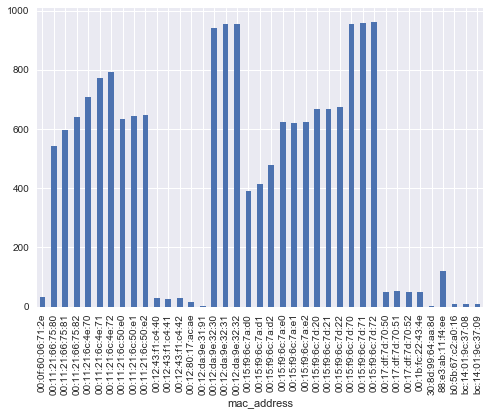

In [14]:
wifi_results_mac_address_group = wifi_results.groupby("mac_address")
wifi_results_mac_address_group.size().plot(kind="bar")
wifi_results_mac_address_group.size()

In [15]:
wifi_results_mac_address_group.size().mean()

444.7692307692308

### How many Wi-Fi results were gathered at each location

x      y    
0.25   0.75     475
2.25   0.75     520
4.25   0.75     527
6.25   0.75     575
8.25   0.75     606
10.25  0.75     679
12.25  0.75     700
13.75  1.25     691
       3.25     831
       5.25     869
       7.25     903
       9.25     887
       11.25    866
15.75  11.25    805
17.75  11.25    828
19.75  11.25    754
21.75  11.25    683
23.75  11.25    729
25.75  11.25    661
27.75  11.25    612
29.75  11.25    601
31.75  11.25    612
33.75  11.25    632
35.75  11.25    632
37.75  11.25    668
dtype: int64

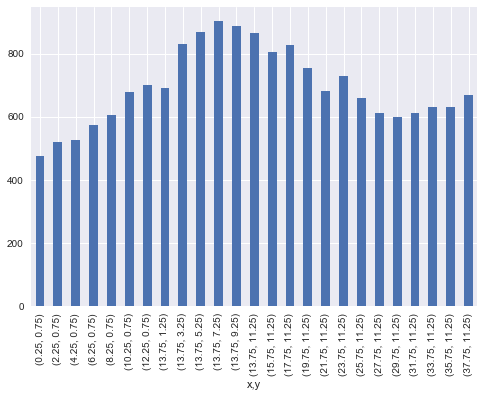

In [16]:
wifi_results_coord_group = wifi_results.groupby(["x", "y"])
wifi_results_coord_group.size().plot(kind="bar")
wifi_results_coord_group.size()

In [17]:
wifi_results_coord_group.size().mean()

693.84

## How many APs were detected at each location

x      y    
0.25   0.75     18
2.25   0.75     19
4.25   0.75     19
6.25   0.75     16
8.25   0.75     18
10.25  0.75     20
12.25  0.75     21
13.75  1.25     21
       3.25     24
       5.25     25
       7.25     26
       9.25     25
       11.25    24
15.75  11.25    24
17.75  11.25    21
19.75  11.25    22
21.75  11.25    18
23.75  11.25    22
25.75  11.25    19
27.75  11.25    19
29.75  11.25    16
31.75  11.25    19
33.75  11.25    21
35.75  11.25    21
37.75  11.25    22
dtype: int64

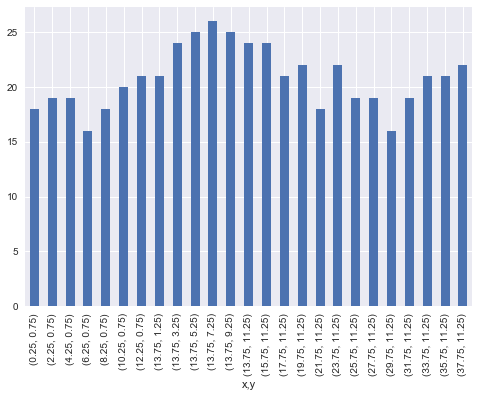

In [18]:
wifi_ap_per_location = wifi_samples.groupby(["x","y"]).min()[wifi_results_mac_address_group.size().keys()].count(axis=1)
wifi_ap_per_location.plot(kind="bar")
wifi_ap_per_location

In [19]:
wifi_ap_per_location.mean()

20.8

### The coordinates of the points where data was captured

(-1.625, 39.625, 0.22499999999999998, 11.775)

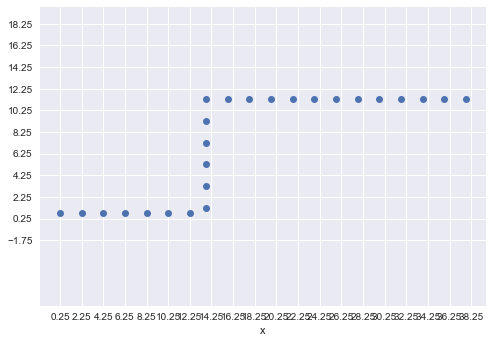

In [20]:
coords = wifi_results[["x","y"]].drop_duplicates().sort_values(by=["x","y"]).reset_index(drop=True)
coords_plot_size = (min(coords["x"].min(),coords["y"].min())-2, max(coords["x"].max(),coords["y"].max())+2)
coords.plot(x="x",y="y", style="o", grid=True, legend=False,
            xlim=coords_plot_size, ylim=coords_plot_size,
            xticks=np.arange(coords_plot_size[0], coords_plot_size[1], 2),
            yticks=np.arange(coords_plot_size[0], coords_plot_size[1], 2)).axis('equal')

### Signal Strength Distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C2D2D1CF28>]], dtype=object)

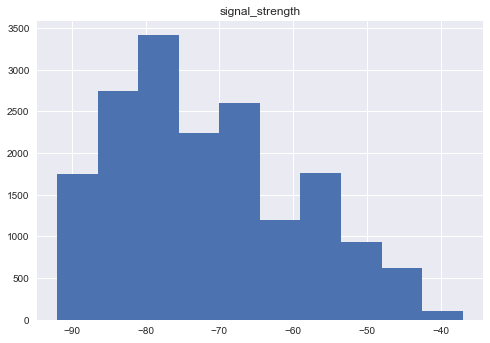

In [21]:
wifi_results.hist(column="signal_strength")

Set a train and test scenario to be used by default when testing.

In [22]:
train_cols = mac_addresses
coord_cols = ["x","y"]

default_data_scenario = wifi_samples.copy()
default_data_scenario_groups = default_data_scenario["x"].map(str)+","+default_data_scenario["y"].map(str)

## Playground

### # Neighbors & Distance Weights

,k,weights,mean_absolute_error,std_dev_distance_error,mean_squared_error,percentile_25,percentile_50,percentile_75,percentile_90,percentile_95,min,max
33,17,distance,2.075707,1.152349,5.635141,1.297841,2.000000,2.751959,3.631104,4.131764,0.002350,7.275868
37,19,distance,2.076249,1.158471,5.651525,1.271847,2.000000,2.769058,3.646688,4.179433,0.002198,6.860739
29,15,distance,2.078653,1.154523,5.652392,1.306341,2.000000,2.745414,3.631983,4.193252,0.001298,7.430791
35,18,distance,2.077343,1.157162,5.653040,1.261052,2.000000,2.774437,3.620001,4.134502,0.003265,7.108615
31,16,distance,2.079158,1.155835,5.657516,1.302334,2.000000,2.741545,3.614315,4.176096,0.003153,7.577996
41,21,distance,2.075277,1.170237,5.674860,1.219196,2.000000,2.820564,3.654421,4.163440,0.004447,6.784986
39,20,distance,2.079516,1.163203,5.676072,1.245675,2.000000,2.807039,3.650747,4.091513,0.005505,6.913347
49,25,distance,2.064087,1.190670,5.676733,1.148164,2.000000,2.869489,3.649748,4.112247,0.000892,6.523337
43,22,distance,2.074744,1.172849,5.678761,1.196492,2.000000,2.826463,3.647760,4.114994,0.001277,6.920270
45,23,distance,2.074425,1.174694,5.681764,1.198680,2.000000,2.855515,3.649125,4.127990,0.001068,6.803534


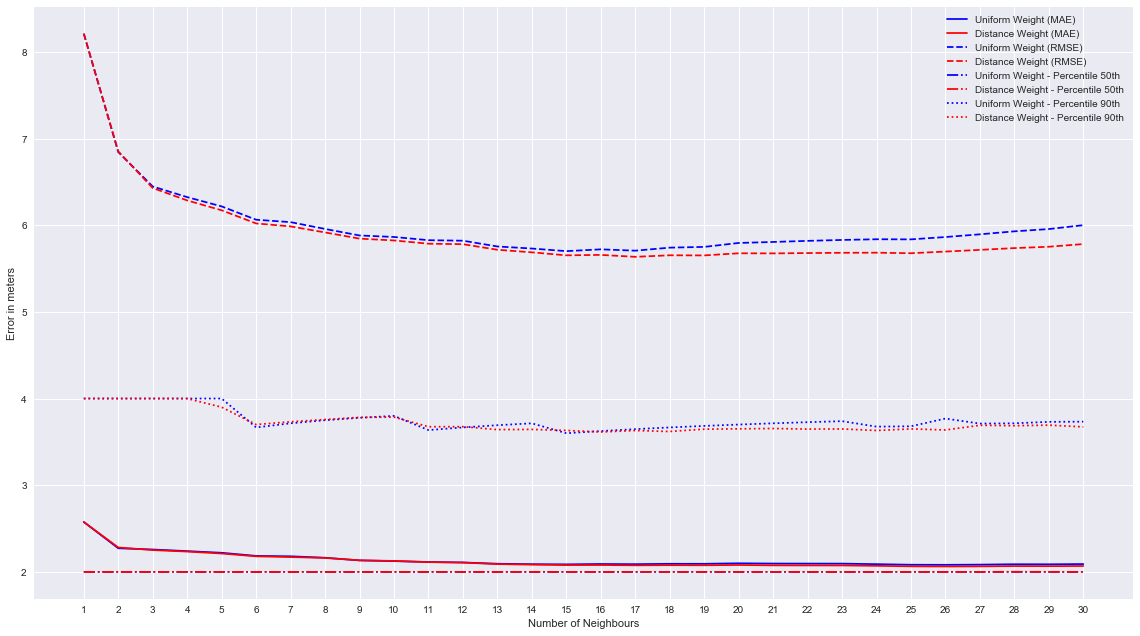

In [23]:
n_neighbors=np.arange(1,31,1)
weights=["uniform", "distance"]
metric="braycurtis"
nan_filler = default_data_scenario[mac_addresses].min().min()*1.001
scaler = preprocessing.StandardScaler()
cross_validation = LeaveOneGroupOut()

curr_data  = default_data_scenario.fillna(nan_filler)

# Just a metrics accumulator
metrics = []
for k in n_neighbors:
    for w in weights:
        curr_result = knn_experiment_cv(curr_data,
                                        cross_validation.split(curr_data[mac_addresses],
                                                               curr_data[coord_cols],
                                                               groups=default_data_scenario_groups),
                                        mac_addresses,
                                        coord_cols,
                                        scaler=scaler,
                                        algorithm="brute",
                                        n_neighbors=k,
                                        weights=w,
                                        metric=metric)
        
        curr_metrics = experiment_metrics(curr_result)
        curr_metrics["k"] = k
        curr_metrics["weights"] = w
        metrics.append(curr_metrics)
    
cols = ["k","weights"] + list(curr_metrics.keys())[:-2]
metrics_table = pd.DataFrame(metrics, columns=cols)
metrics_table.to_csv(output_data_directory + "/metrics-neighbors-weights.csv")

#show table
display(metrics_table.sort_values(cols[4:]))

# Plotting Error Metrics
fig, ax = plt.subplots(figsize=(16, 9))
index = n_neighbors

plt.plot(index, metrics_table[metrics_table["weights"] == "uniform"]["mean_absolute_error"].tolist(),
         color="b", ls="-", label="Uniform Weight (MAE)")

plt.plot(index, metrics_table[metrics_table["weights"] == "distance"]["mean_absolute_error"].tolist(),
         color="r", ls="-", label="Distance Weight (MAE)")

plt.plot(index, metrics_table[metrics_table["weights"] == "uniform"]["mean_squared_error"].tolist(),
         color="b", ls="--", label="Uniform Weight (RMSE)")

plt.plot(index, metrics_table[metrics_table["weights"] == "distance"]["mean_squared_error"].tolist(),
         color="r", ls="--", label="Distance Weight (RMSE)")

plt.plot(index, metrics_table[metrics_table["weights"] == "uniform"]["percentile_50"].tolist(),
         color="b", ls="-.", label="Uniform Weight - Percentile 50th")

plt.plot(index, metrics_table[metrics_table["weights"] == "distance"]["percentile_50"].tolist(),
         color="r", ls="-.", label="Distance Weight - Percentile 50th")

plt.plot(index, metrics_table[metrics_table["weights"] == "uniform"]["percentile_90"].tolist(),
         color="b", ls=":", label="Uniform Weight - Percentile 90th")

plt.plot(index, metrics_table[metrics_table["weights"] == "distance"]["percentile_90"].tolist(),
         color="r", ls=":", label="Distance Weight - Percentile 90th")

plt.xlabel("Number of Neighbours")
plt.ylabel("Error in meters")
plt.xticks(index, index)

plt.legend()
plt.tight_layout()
plt.savefig(output_data_directory+"/metrics-neighbors-weights.pdf", dpi=300)
plt.show()

### Metric
Just test a few different distance metrics to assess if there is a better alternative than the plain old *euclidean* distance. The tested metrics include:
- Euclidean Distance
    - sqrt(sum((x - y)^2))
- Manhattan Distance
    - sum(|x - y|) 
- Chebyshev Distance
    - sum(max(|x - y|))
- Hamming Distance
    - N_unequal(x, y) / N_tot
- Canberra Distance
    - sum(|x - y| / (|x| + |y|))
- Braycurtis Similarity
    - sum(|x - y|) / (sum(|x|) + sum(|y|))

,metric,mean_absolute_error,std_dev_distance_error,mean_squared_error,percentile_25,percentile_50,percentile_75,percentile_90,percentile_95,min,max
3,braycurtis,2.078653,1.154523,5.652392,1.306341,2.000000,2.745414,3.631983,4.193252,0.001298,7.430791
2,canberra,2.070815,1.206274,5.741915,1.184405,2.000000,2.780921,3.791733,4.319201,0.028864,6.933314
1,manhattan,2.125824,1.190514,5.935033,1.392154,2.000000,2.752557,3.673767,4.211570,0.001575,8.266667
0,euclidean,2.304611,1.680734,8.133273,1.453531,2.006514,3.035926,3.948149,4.395501,0.009308,22.212709


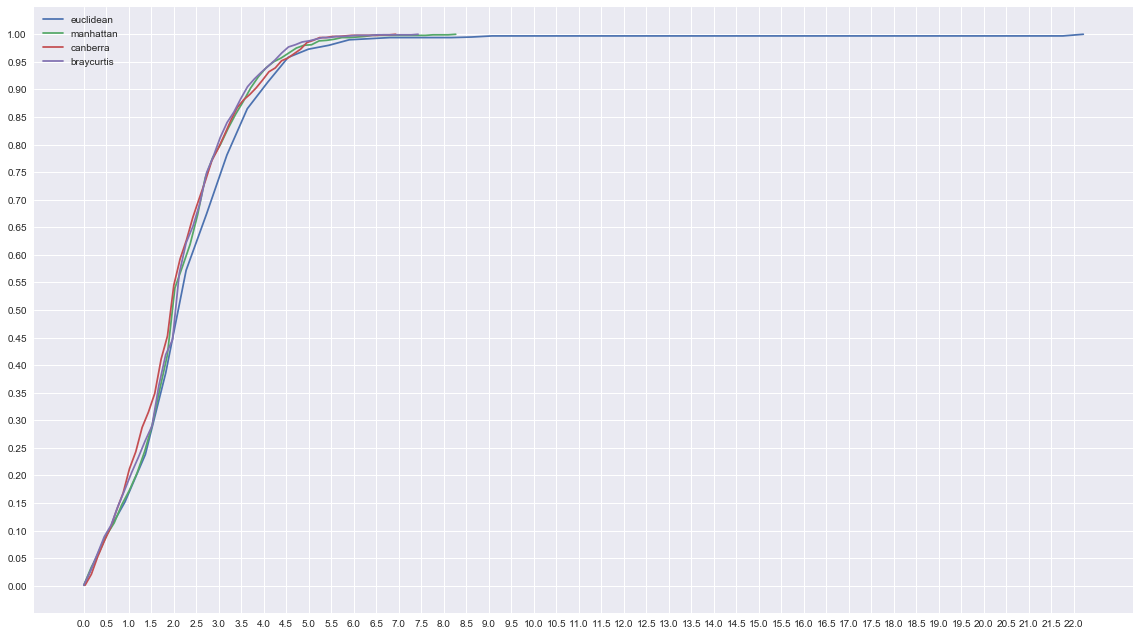

In [24]:
fig, ax = plt.subplots(figsize=(16, 9))

n_neighbors=15
weights="distance"
metric=["euclidean",
        "manhattan",
        "canberra",
        "braycurtis"]

nan_filler = default_data_scenario[mac_addresses].min().min()*1.001
scaler = preprocessing.StandardScaler()
cross_validation = LeaveOneGroupOut()

curr_data = default_data_scenario.fillna(nan_filler)

# Just a metrics accumulator
metrics = []
for m in metric:
    curr_result = knn_experiment_cv(curr_data,
                                    cross_validation.split(curr_data[mac_addresses],
                                                           curr_data[coord_cols],
                                                           groups=default_data_scenario_groups),
                                    mac_addresses,
                                    coord_cols,
                                    scaler=scaler,
                                    algorithm="brute",
                                    n_neighbors=n_neighbors,
                                    weights=weights,
                                    metric=m)
    curr_metrics = experiment_metrics(curr_result)
    curr_metrics["metric"] = m
    metrics.append(curr_metrics)
    
    ecdf = sm.distributions.ECDF(curr_result["error"])
    x = np.linspace(min(curr_result["error"]), max(curr_result["error"]))
    y = ecdf(x)
    plt.plot(x, y, label=m)

cols = ["metric"] + list(curr_metrics.keys())[:-1]
metrics_table = pd.DataFrame(metrics, columns=cols)
metrics_table.to_csv(output_data_directory + "/metrics-metric.csv")

plt.xticks(np.arange(min(metrics_table["min"]), max(metrics_table["max"]), 0.5))
plt.yticks(np.linspace(0.0,1.0,num=21))

plt.legend()
plt.tight_layout()
plt.savefig(output_data_directory+"/cdf-metric.pdf", dpi=300)

#show table
display(metrics_table.sort_values(cols[3:]))
#show graph
plt.show()

### Scaler
Test different data scaling and normalization approaches to find out if any of them provides a clear advantage over the others.

,scaler,mean_absolute_error,std_dev_distance_error,mean_squared_error,percentile_25,percentile_50,percentile_75,percentile_90,percentile_95,min,max
2,Standardizing,2.078653,1.154523,5.652392,1.306341,2.0,2.745414,3.631983,4.193252,0.001298,7.430791
1,Rescaling,2.154491,1.231249,6.156292,1.466071,2.0,2.839237,3.734635,4.147790,0.012591,8.006142
0,None,2.203234,1.340423,6.649175,1.361940,2.0,2.918448,3.944852,4.724775,0.000274,8.980178


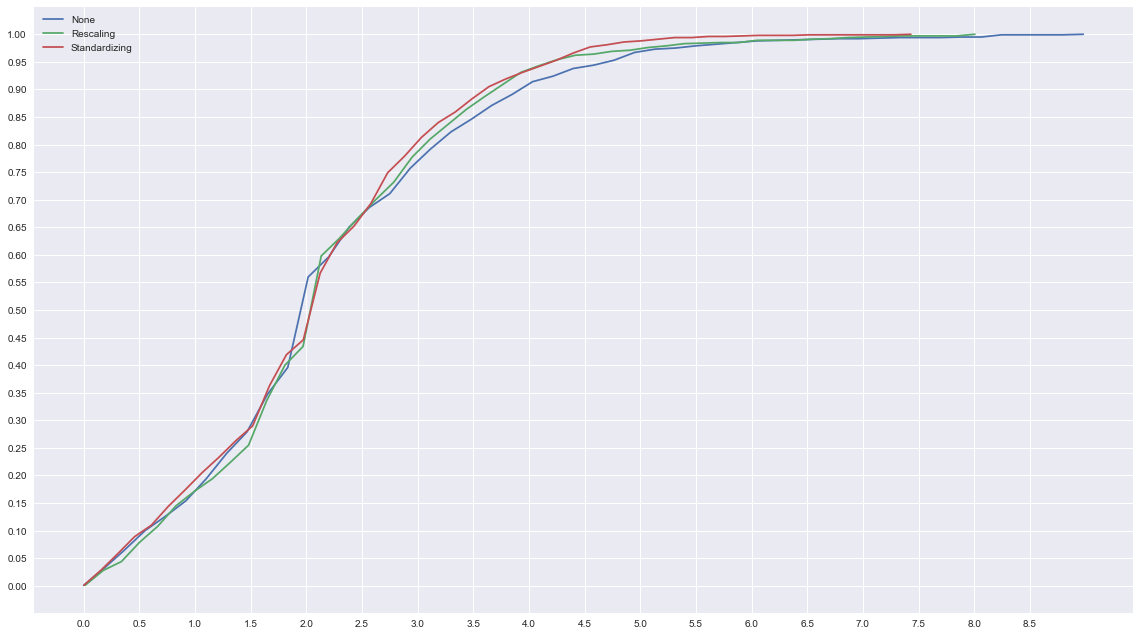

In [25]:
fig, ax = plt.subplots(figsize=(16, 9))

n_neighbors=15
weights="distance"
metric="braycurtis"
nan_filler= default_data_scenario[mac_addresses].min().min()*1.001
cross_validation = LeaveOneGroupOut()

scaler_values = {"None": None,
                 "Rescaling": preprocessing.MinMaxScaler(),
                 "Standardizing": preprocessing.StandardScaler()}

# Just a metrics accumulator
metrics = []
for scaler_name, scaler in scaler_values.items():
    curr_data = default_data_scenario.fillna(nan_filler)
    curr_result = knn_experiment_cv(curr_data,
                                    cross_validation.split(curr_data[mac_addresses],
                                                           curr_data[coord_cols],
                                                           groups=default_data_scenario_groups),
                                    mac_addresses,
                                    coord_cols,
                                    scaler=scaler,
                                    algorithm="brute",
                                    n_neighbors=n_neighbors,
                                    weights=weights,
                                    metric=metric)
    
    curr_metrics = experiment_metrics(curr_result)
    curr_metrics["scaler"] = scaler_name
    metrics.append(curr_metrics)
    
    ecdf = sm.distributions.ECDF(curr_result["error"])
    x = np.linspace(min(curr_result["error"]), max(curr_result["error"]))
    y = ecdf(x)
    plt.plot(x, y, label=scaler_name)

cols = ["scaler"] + list(curr_metrics.keys())[:-1]
metrics_table = pd.DataFrame(metrics, columns=cols)
metrics_table.to_csv(output_data_directory + "/metrics-scaler.csv")

plt.xticks(np.arange(min(metrics_table["min"]), max(metrics_table["max"]), 0.5))
plt.yticks(np.linspace(0.0,1.0,num=21))

plt.legend()
plt.tight_layout()
plt.savefig(output_data_directory+"/cdf-scaler.pdf", dpi=300)

#show table
display(metrics_table.sort_values(cols[3:]))
#show graph
plt.show()

### NaN filler values
Test which is the signal strength value that should be considered for Access Points that are currently out of range. This is needed as part of the process of computing the distance/similarity between different fingerprints.

,nan_filler,mean_absolute_error,std_dev_distance_error,mean_squared_error,percentile_25,percentile_50,percentile_75,percentile_90,percentile_95,min,max
1,-92.092,2.078653,1.154523,5.652392,1.306341,2.00000,2.745414,3.631983,4.193252,0.001298,7.430791
2,-92.920,2.078960,1.159507,5.665186,1.303063,2.00000,2.773798,3.629042,4.153457,0.000967,7.491982
0,-92.000,2.088900,1.167969,5.726292,1.303272,2.00000,2.744989,3.633771,4.196731,0.002054,7.501539
3,-101.200,2.086407,1.195442,5.780747,1.252525,2.00000,2.889136,3.669568,4.110202,0.002409,7.040686
4,-138.000,2.307689,1.380389,7.228996,1.353600,2.09817,3.147668,4.000581,4.818592,0.001288,7.593842


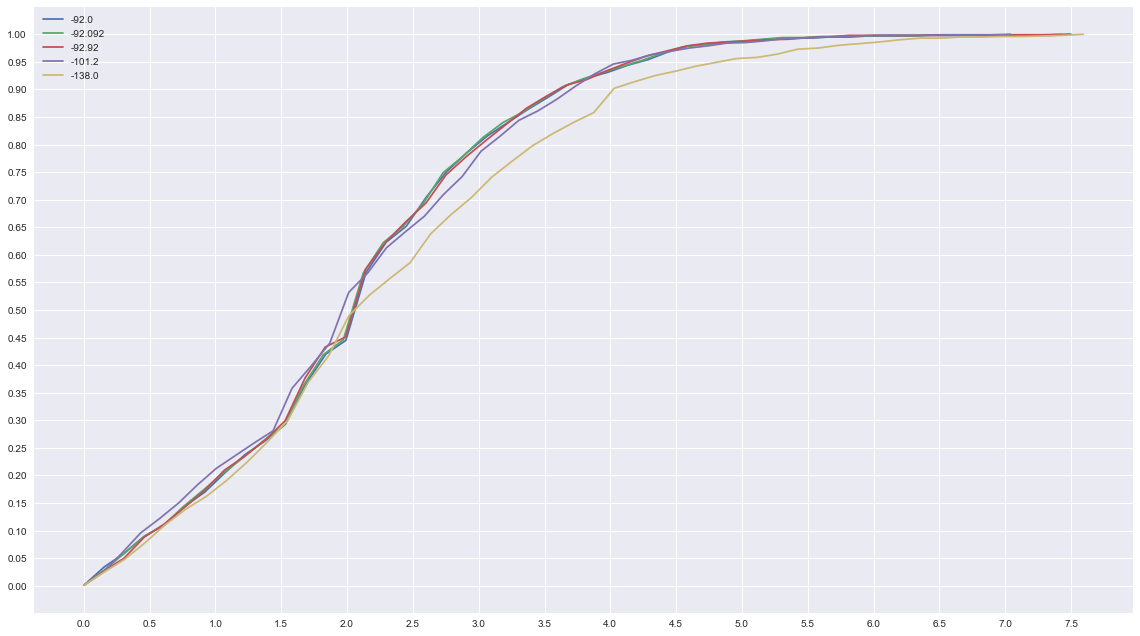

In [26]:
fig, ax = plt.subplots(figsize=(16, 9))

n_neighbors=15
weights="distance"
metric="braycurtis"
nan_filler = [default_data_scenario[mac_addresses].min().min(),
              default_data_scenario[mac_addresses].min().min()*1.001,
              default_data_scenario[mac_addresses].min().min()*1.010,
              default_data_scenario[mac_addresses].min().min()*1.100,
              default_data_scenario[mac_addresses].min().min()*1.500]

scaler = preprocessing.StandardScaler()
cross_validation = LeaveOneGroupOut()

# Just a metrics accumulator
metrics = []
for nf in nan_filler:
    curr_data = default_data_scenario.fillna(nf)
    curr_result = knn_experiment_cv(curr_data,
                                    cross_validation.split(curr_data[mac_addresses],
                                                           curr_data[coord_cols],
                                                           groups=default_data_scenario_groups),
                                    mac_addresses,
                                    coord_cols,
                                    scaler=scaler,
                                    algorithm="brute",
                                    n_neighbors=n_neighbors,
                                    weights=weights,
                                    metric=metric)
    
    curr_metrics = experiment_metrics(curr_result)
    curr_metrics["nan_filler"] = nf
    metrics.append(curr_metrics)
    
    ecdf = sm.distributions.ECDF(curr_result["error"])
    x = np.linspace(min(curr_result["error"]), max(curr_result["error"]))
    y = ecdf(x)
    plt.plot(x, y, label=nf)

cols = ["nan_filler"] + list(curr_metrics.keys())[:-1]
metrics_table = pd.DataFrame(metrics, columns=cols)
metrics_table.to_csv(output_data_directory + "/metrics-nan_filler.csv")

plt.xticks(np.arange(min(metrics_table["min"]), max(metrics_table["max"]), 0.5))
plt.yticks(np.linspace(0.0,1.0,num=21))

plt.legend()
plt.tight_layout()
plt.savefig(output_data_directory+"/cdf-nan_filler.pdf", dpi=300)

#show table
display(metrics_table.sort_values(cols[3:]))
#show graph
plt.show()

### Impact of orientation in the results

,orientation,mean_absolute_error,std_dev_distance_error,mean_squared_error,percentile_25,percentile_50,percentile_75,percentile_90,percentile_95,min,max
0,Train: left-to-right-point Test:left-to-right-...,2.078508,1.198329,5.753316,1.293002,2.035648,2.742955,3.454114,4.118626,2.818865e-03,7.359108
3,Train: right-to-left-point Test:right-to-left-...,2.108240,1.236409,5.970324,1.295125,2.000000,2.780447,3.721208,4.549109,3.037623e-02,7.345844
2,Train: right-to-left-point Test:left-to-right-...,2.344952,1.452188,7.603434,1.491857,2.120310,3.005699,4.560532,5.347580,9.237604e-03,8.000000
1,Train: left-to-right-point Test:right-to-left-...,2.465425,1.378966,7.976066,1.553214,2.124233,3.480434,4.247193,4.735090,8.950904e-16,6.551945


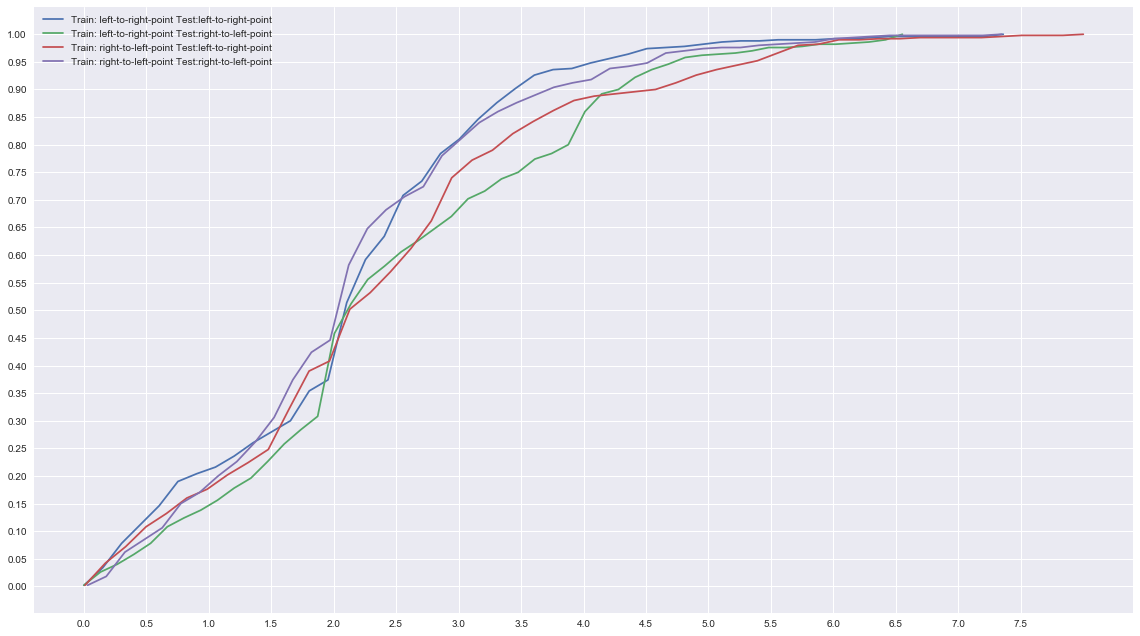

In [27]:
fig, ax = plt.subplots(figsize=(16, 9))

filename_prefixes = ["left-to-right-point", "right-to-left-point"]

filename_prefix_data_scenarios = {}
for filename_prefix in filename_prefixes:
    filename_prefix_data_scenarios[filename_prefix] = default_data_scenario[wifi_samples["filename"].str.startswith(filename_prefix)].reset_index(drop=True)
    
filename_prefix_test_data_scenarios = {}
for filename_prefix in filename_prefixes:
    filename_prefix_test_data_scenarios[filename_prefix] = default_data_scenario[wifi_samples["filename"].str.startswith(filename_prefix)].reset_index(drop=True)

n_neighbors=15
weights="distance"
metric="braycurtis"
nan_filler = default_data_scenario[mac_addresses].min().min()*1.001
scaler = preprocessing.StandardScaler()

# Just a metrics accumulator
metrics = []
for train_data_keys, train_data in filename_prefix_data_scenarios.items():
    for test_data_keys, test_data in filename_prefix_test_data_scenarios.items():
        curr_data = train_data.fillna(nan_filler)
        curr_test_data = test_data.fillna(nan_filler)
        curr_result = knn_experiment(curr_data,
                                     curr_test_data,
                                     mac_addresses,
                                     coord_cols,
                                     scaler=scaler,
                                     algorithm="brute",
                                     n_neighbors=n_neighbors,
                                     weights=weights,
                                     metric=metric)
        
        curr_metrics = experiment_metrics(curr_result)
        curr_metrics["orientation"] = "Train: "+train_data_keys+" Test:"+test_data_keys
        metrics.append(curr_metrics)

        ecdf = sm.distributions.ECDF(curr_result["error"])
        x = np.linspace(min(curr_result["error"]), max(curr_result["error"]))
        y = ecdf(x)
        plt.plot(x, y, label="Train: "+train_data_keys+" Test:"+test_data_keys)
    
cols = ["orientation"] + list(curr_metrics.keys())[:-1]
metrics_table = pd.DataFrame(metrics, columns=cols)
metrics_table.to_csv(output_data_directory + "/metrics-orientation.csv")

plt.xticks(np.arange(min(metrics_table["min"]), max(metrics_table["max"]), 0.5))
plt.yticks(np.linspace(0.0,1.0,num=21))

plt.legend()
plt.tight_layout()
plt.savefig(output_data_directory+"/cdf-orientation.pdf", dpi=300)

#show table
display(metrics_table.sort_values(cols[3:]))
#show graph
plt.show()

### Impact of the number of locations in the results

,location_subset,mean_absolute_error,std_dev_distance_error,mean_squared_error,percentile_25,percentile_50,percentile_75,percentile_90,percentile_95,min,max
0,all_locations,2.078653,1.154523,5.652392,1.306341,2.0,2.745414,3.631983,4.193252,0.001298,7.430791
1,odd_locations,3.640083,1.372463,15.130240,3.004079,4.0,4.225830,4.899383,5.699411,0.004238,8.660702
2,even_locations,4.058169,1.491183,18.687732,3.535534,4.0,4.804449,5.897443,6.732381,0.040384,7.754048


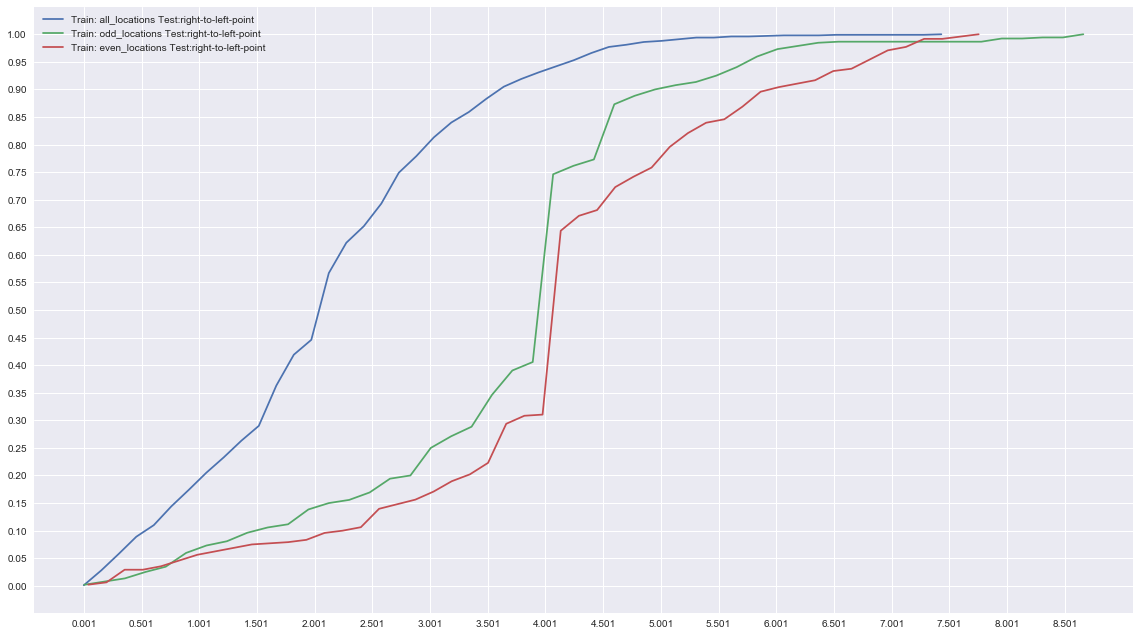

In [28]:
fig, ax = plt.subplots(figsize=(16, 9))

subset_location_data_scenarios = {}

locations_coords_indices = default_data_scenario.groupby(coord_cols).indices
sampled_locations_coords_keys = list(locations_coords_indices.keys())[::2]
ids = []
for key in sampled_locations_coords_keys:
    ids.extend(locations_coords_indices[key])

subset_location_data_scenarios["all_locations"] = default_data_scenario
subset_location_data_scenarios["odd_locations"] = default_data_scenario.loc[ids].reset_index(drop=True)
subset_location_data_scenarios["even_locations"] = default_data_scenario.loc[set(default_data_scenario.index)-set(ids)].reset_index(drop=True)

n_neighbors=15
weights="distance"
metric="braycurtis"
nan_filler = default_data_scenario[mac_addresses].min().min()*1.001
scaler = preprocessing.StandardScaler()

# Just a metrics accumulator
metrics = []
for train_data_keys, train_data in subset_location_data_scenarios.items():
    curr_data = train_data.fillna(nan_filler)
    curr_test_data = default_data_scenario.fillna(nan_filler)
    curr_result = knn_experiment(curr_data,
                                 curr_test_data,
                                 mac_addresses,
                                 coord_cols,
                                 scaler=scaler,
                                 algorithm="brute",
                                 n_neighbors=n_neighbors,
                                 weights=weights,
                                 metric=metric)

    curr_metrics = experiment_metrics(curr_result)
    curr_metrics["location_subset"] = train_data_keys
    metrics.append(curr_metrics)

    ecdf = sm.distributions.ECDF(curr_result["error"])
    x = np.linspace(min(curr_result["error"]), max(curr_result["error"]))
    y = ecdf(x)
    plt.plot(x, y, label="Train: "+train_data_keys+" Test:"+test_data_keys)
    
cols = ["location_subset"] + list(curr_metrics.keys())[:-1]
metrics_table = pd.DataFrame(metrics, columns=cols)
metrics_table.to_csv(output_data_directory + "/metrics-location_subset.csv")

plt.xticks(np.arange(min(metrics_table["min"]), max(metrics_table["max"]), 0.5))
plt.yticks(np.linspace(0.0,1.0,num=21))

plt.legend()
plt.tight_layout()
plt.savefig(output_data_directory+"/cdf-location_subset.pdf", dpi=300)

#show table
display(metrics_table.sort_values(cols[3:]))
#show graph
plt.show()

### Impact of the amount of available data in the results

,partial_data,mean_absolute_error,std_dev_distance_error,mean_squared_error,percentile_25,percentile_50,percentile_75,percentile_90,percentile_95,min,max
0,0.90,2.068111,1.161923,5.626875,1.268526,2.000000,2.717109,3.606079,4.161555,0.001205,7.544913
1,0.75,2.090885,1.187303,5.781374,1.232484,2.000000,2.830010,3.650534,4.184952,0.000110,8.489856
2,0.50,2.084386,1.252062,5.912263,1.086169,2.004481,2.942920,3.696519,4.238827,0.000275,8.476618
3,0.25,2.218148,1.368435,6.792744,1.089237,2.159865,3.218183,4.015574,4.515731,0.000049,7.386973
4,0.10,2.583064,1.635576,9.347268,1.252037,2.391212,3.747540,4.902970,5.541441,0.000076,7.949134


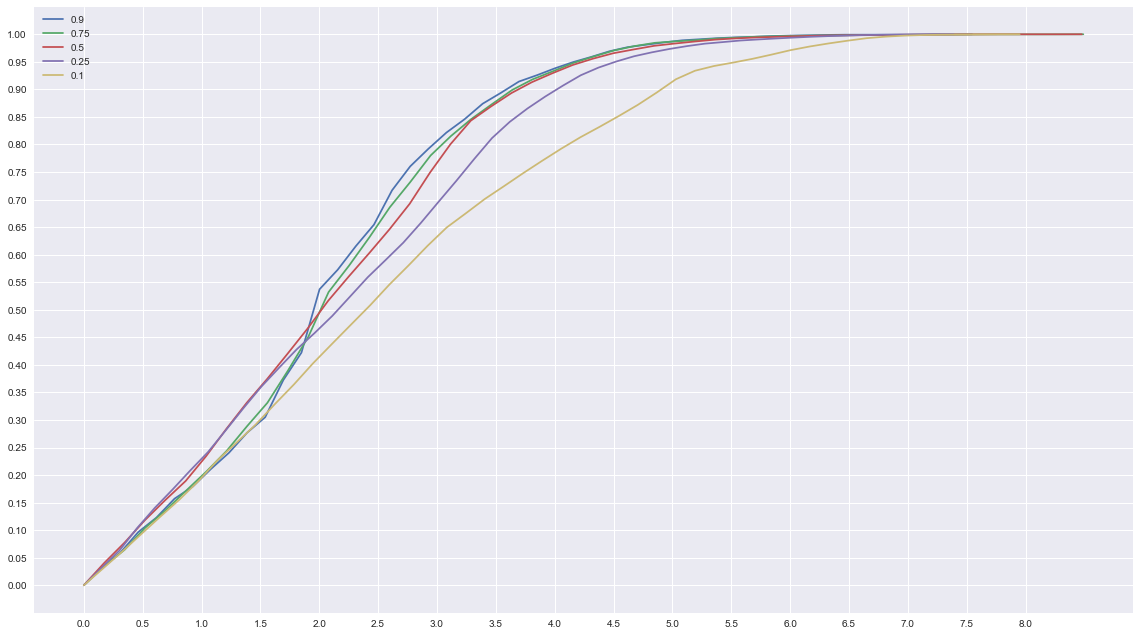

In [29]:
fig, ax = plt.subplots(figsize=(16, 9))
# Data Scenarios using sklearn's train_test_split

n_neighbors=15
weights="distance"
metric="braycurtis"
nan_filler = default_data_scenario[mac_addresses].min().min()*1.001
scaler = preprocessing.StandardScaler()

partial_data = [0.9, 0.75, 0.5, 0.25, 0.1]
repetitions = 50
train_data = default_data_scenario[mac_addresses].copy()
target_values = default_data_scenario[coord_cols].copy()
target_values["label"] = default_data_scenario["x"].map(str) + "," + default_data_scenario["y"].map(str)+ "," + default_data_scenario["filename"].map(str)

# Just a metrics accumulator
metrics = []
for partial in partial_data:
    curr_result = pd.DataFrame()
    for repetition in range(repetitions):
        X_train, X_test, y_train, y_test = train_test_split(train_data,
                                                            target_values,
                                                            test_size=1-partial,
                                                            stratify=target_values["label"].values)
        #train data
        train_split_data = pd.concat([y_train, X_train], axis=1).reset_index(drop=True)
        #test data
        test_split_data = pd.concat([y_test, X_test], axis=1).reset_index(drop=True)
        
        curr_data = train_split_data.fillna(nan_filler)
        curr_test_data = test_split_data.fillna(nan_filler)
        curr_result = curr_result.append(knn_experiment(curr_data,
                                         curr_test_data,
                                         mac_addresses,
                                         coord_cols,
                                         scaler=scaler,
                                         algorithm="brute",
                                         n_neighbors=n_neighbors,
                                         weights=weights,
                                         metric=metric), ignore_index=True)
    
    curr_metrics = experiment_metrics(curr_result)
    curr_metrics["partial_data"] = partial
    metrics.append(curr_metrics)

    ecdf = sm.distributions.ECDF(curr_result["error"])
    x = np.linspace(min(curr_result["error"]), max(curr_result["error"]))
    y = ecdf(x)
    plt.plot(x, y, label=partial)
    
cols = ["partial_data"] + list(curr_metrics.keys())[:-1]
metrics_table = pd.DataFrame(metrics, columns=cols)
metrics_table.to_csv(output_data_directory + "/metrics-partial_data.csv")

plt.xticks(np.arange(min(metrics_table["min"]), max(metrics_table["max"]), 0.5))
plt.yticks(np.linspace(0.0,1.0,num=21))

plt.legend()
plt.tight_layout()
plt.savefig(output_data_directory+"/cdf-partial_data.pdf", dpi=300)

#show table
display(metrics_table.sort_values(cols[3:]))
#show graph
plt.show()

## Grid Search - Automatically searching for the best estimator parameters

In [30]:
k_neighbors_values = range(1,31,1)
weights_values = [
                    "uniform",
                    "distance"
                 ]
metric_values = [
                    "euclidean",
                    "manhattan",
                    "canberra", 
                    "braycurtis"
                ]
algorithm_values = ["brute"]

nan_filler = default_data_scenario[mac_addresses].min().min()*1.001
curr_data = default_data_scenario.fillna(nan_filler)

param_grid = {
                "kneighborsregressor__n_neighbors": list(k_neighbors_values),
                "kneighborsregressor__weights": weights_values,
                "kneighborsregressor__metric": metric_values,
                "kneighborsregressor__algorithm": algorithm_values,
              }

scaler = preprocessing.StandardScaler()
cross_validation = LeaveOneGroupOut()
estimator = make_pipeline(preprocessing.StandardScaler(), KNeighborsRegressor())

grid = GridSearchCV(estimator,
                    param_grid=param_grid,
                    cv=cross_validation,
                    n_jobs=-1,
                    scoring=sklearn.metrics.make_scorer(sklearn.metrics.mean_squared_error,
                                                        greater_is_better=False,
                                                        multioutput="uniform_average"))

grid.fit(curr_data[mac_addresses], curr_data[coord_cols], default_data_scenario_groups)
print("Best parameters set found on development set:")
print(grid.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in grid.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r" %(mean_score, scores.std() * 2, params))

Best parameters set found on development set:
{'kneighborsregressor__algorithm': 'brute', 'kneighborsregressor__metric': 'canberra', 'kneighborsregressor__n_neighbors': 30, 'kneighborsregressor__weights': 'distance'}
Grid scores on development set:
-6.694 (+/-21.451) for {'kneighborsregressor__algorithm': 'brute', 'kneighborsregressor__metric': 'euclidean', 'kneighborsregressor__n_neighbors': 1, 'kneighborsregressor__weights': 'uniform'}
-6.694 (+/-21.451) for {'kneighborsregressor__algorithm': 'brute', 'kneighborsregressor__metric': 'euclidean', 'kneighborsregressor__n_neighbors': 1, 'kneighborsregressor__weights': 'distance'}
-6.256 (+/-21.583) for {'kneighborsregressor__algorithm': 'brute', 'kneighborsregressor__metric': 'euclidean', 'kneighborsregressor__n_neighbors': 2, 'kneighborsregressor__weights': 'uniform'}
-6.245 (+/-21.591) for {'kneighborsregressor__algorithm': 'brute', 'kneighborsregressor__metric': 'euclidean', 'kneighborsregressor__n_neighbors': 2, 'kneighborsregressor_

c:\developmenttools\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
